<a href="https://colab.research.google.com/github/shashankyadahalli/AppsThatYouRequire.github.io/blob/master/Pca_DWSI_HoverNet_VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**HOVERNET SEGMENTATION OF PROSTATE CANCER**<br/>
  <h1>Preprocessing Steps:</h1><br/>
  <ol>
  <li><b>Normalization of Image Intensity</b></li>
     First Reading Image using ImRead ad Then converting Image to Gray Scale,<b>Contrast Limited Adaptive Histogram Equalization (CLAHE)</b> to equalize images. CLAHE is a variant of Adaptive histogram equalization (AHE) which takes care of over-amplification of the contrast. CLAHE operates on small regions in the image, called tiles, rather than the entire image. After Coverting Gray to RGB Image
  <li><b>Removing noise and artifacts</b></li>
      The function first applies the <b>Median filter</b> to remove salt-and-pepper noise using the cv2.medianBlur function from the OpenCV library, with a kernel size of 3x3. Then, it applies the <b>Bilateral filter</b> to smooth the image while preserving edges using the cv2.bilateralFilter function, with a window size of 9x9, and sigma values of 75 for both spatial and intensity domains.
   <li><b>Transforming the Image</b></li>
   Here we gonna Resize the Image to 244*244 Pixels, so that for further image processing it become easier, After which we convert the Image to Tensor and UnSqueeze the Image. For which we use <b>Numpy and PyTorch</b> modules
  </ol>

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
tensor([[[0.7647, 0.7647, 0.7647,  ..., 0.6314, 0.6314, 0.6431],
         [0.7686, 0.7647, 0.7647,  ..., 0.6275, 0.6314, 0.6314],
         [0.7686, 0.7686, 0.7608,  ..., 0.6353, 0.6275, 0.6235],
         ...,
         [0.6745, 0.6706, 0.6706,  ..., 0.8941, 0.8078, 0.7569],
         [0.6784, 0.6824, 0.6824,  ..., 0.8510, 0.7647, 0.7059],
         [0.6824, 0.6824, 0.6941,  ..., 0.8157, 0.7020, 0.6471]],

        [[0.7647, 0.7647, 0.7647,  ..., 0.6314, 0.6314, 0.6431],
         [0.7686, 0.7647, 0.7647,  ..., 0.6275, 0.6314, 0.6314],
         [0.7686, 0.7686, 0.7608,  ..., 0.6353, 0.6275, 0.6235],
         ...,
         [0.6745, 0.6706, 0.6706,  ..., 0.8941, 0.8078, 0.7569],
         [0.6784, 0.6824, 0.6824,  ..., 0.8510, 0.7647, 0.7059],
         [0.6824, 0.6824, 0.6941,  ..., 0.8157, 0.7020, 0.6471]],

        [[0.7647, 0.7647, 0.7647,  ..., 0.6314, 0.6314, 0.6431],
         [0.7686, 0.7647, 0.7647,  ..., 0.6275, 0.6314, 0.6314],
      

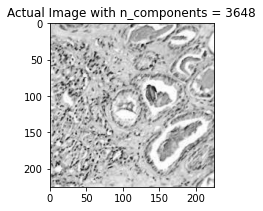

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms


class Preprocessing():
  
 def __init__(self, img):
   self.img=img

 def normalize_intensity(self):
    img = cv2.imread(self.img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_rescale = clahe.apply(gray)
    img_rescale = cv2.cvtColor(img_rescale, cv2.COLOR_GRAY2RGB)
    u, s, v = np.linalg.svd(gray, full_matrices=False)
    return [img_rescale, u, s, v]

 def remove_noise_artifacts(self):
    ResImage=self.normalize_intensity()
    img = ResImage[0]
    img_median = cv2.medianBlur(img, 3)
    img_bilateral = cv2.bilateralFilter(img_median, 9, 75, 75)
    return [img_bilateral, ResImage[1], ResImage[2], ResImage[3]]

 def TransformImage(self):
    gt_trans=transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor()])
    resnt=self.remove_noise_artifacts()
    SqueezeTens=gt_trans(resnt[0])
    print(SqueezeTens.shape)
    torch.unsqueeze(SqueezeTens,0)
    print(SqueezeTens.shape)
    return [SqueezeTens, resnt[1],resnt[2],resnt[3]]

 def Reconstruct_image(self):
    comps = [3648, 1, 5, 10, 15, 20]
    plt.figure(figsize=(10, 70))
    t=self.TransformImage()
    low_rank = t[1][:, :comps[0]] @ np.diag(t[2][:comps[0]]) @ t[3][:comps[0], :]
    plt.subplot(2, 3, 1),
    k=plt.imshow(low_rank,cmap='gray'),
    plt.title(f'Actual Image with n_components = {comps[0]}')
    return t[0]
   


PreProcessedImage=Preprocessing("/content/prostate.jpeg")
p=PreProcessedImage.Reconstruct_image()
print(p)



<ol>
<h1>Backbone network:</h1><br/>
<li><b>VGG16 Backbone</b><br/> The input image is passed through a VGG16 backbone network, which consists of 13 convolutional layers and 5 max pooling layers. The convolutional layers have 3x3 kernels and are designed to extract increasingly complex features from the input image.
</li></ol>

In [ ]:

def VggBackBone(p): 
 vgg16 = models.vgg16(pretrained=True)
 features = list(vgg16.features.children())[:-1]
 vgg16_features = nn.Sequential(*features)
 input_tensor = p
 output_tensor = vgg16_features(input_tensor)
 return(output_tensor)


def ConvolutionalLayer(p):

  conv1 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
  conv2 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)
  conv3 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)

# Pass the output of the last convolutional layer in the VGG16 backbone through the additional convolutional layers
  input_tensor = VggBackBone(p)  # Example input tensor
  output_tensor = conv1(input_tensor)
  output_tensor = conv2(output_tensor)
  output_tensor = conv3(output_tensor)
  return (output_tensor)


def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

tensor_to_image(ConvolutionalLayer(p))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: ignored